In [23]:
import importlib
import subprocess
import sys

def check_installed_and_import(import_dict):
    for module, import_as_tuple in import_dict.items():
        try:
            # Check if the module should be imported using "from x import y" syntax
            if len(import_as_tuple) == 3:
                from_module, import_module, imported_as = import_as_tuple
                imported_module = importlib.import_module(from_module)
                # Add the module to the global namespace under the 'imported_as' alias
                globals()[imported_as] = getattr(imported_module, import_module)
            else:
                import_module, imported_as = import_as_tuple
                imported_module = importlib.import_module(import_module)
                globals()[imported_as] = imported_module
                
            print(f"{module} imported as {imported_as}")
        except Exception as e:
            print(f"FAILED: {module} imported as {imported_as}. Trying to install...")
            try:
                base_module = module.split(".")[0] 
                subprocess.check_call([sys.executable, '-m', 'pip', 'install', base_module])
                
                if len(import_as_tuple) == 3:
                    from_module, import_module, imported_as = import_as_tuple
                    imported_module = importlib.import_module(from_module)
                    globals()[imported_as] = getattr(imported_module, import_module)
                else:
                    import_module, imported_as = import_as_tuple
                    imported_module = importlib.import_module(import_module)
                    globals()[imported_as] = imported_module
                
                print(f"{module} imported as {imported_as}")
            except Exception as e:
                print(f"FAILED: {module} imported as {imported_as}. Error: {e}")


In [31]:
check_installed_and_import({
    'pandas': ('pandas', 'pd'),
    'numpy': ('numpy', 'np'),
    'matplotlib.pyplot': ('matplotlib', 'pyplot', 'plt'),
    'os': ('os', 'os'),
    'datetime': ('datetime', 'datetime'),
    'sklearn.metrics.mean_squared_error': ('sklearn.metrics', 'mean_squared_error', 'mean_squared_error'),
    'sklearn.preprocessing.MinMaxScaler': ('sklearn.preprocessing', 'MinMaxScaler', 'MinMaxScaler'),
    'tensorflow': ('tensorflow', 'tf'),
    'tensorflow.keras.models.Sequential': ('tensorflow.keras.models', 'Sequential', 'Sequential'),
    'tensorflow.keras.layers.Dense': ('tensorflow.keras.layers', 'Dense', 'Dense'),
    'tensorflow.keras.layers.Dropout': ('tensorflow.keras.layers', 'Dropout', 'Dropout'),
    'tensorflow.keras.layers.LSTM': ('tensorflow.keras.layers', 'LSTM', 'LSTM'),
    'alpha_vantage.timeseries': ('alpha_vantage.timeseries', 'TimeSeries', 'TimeSeries'),
    'math': ('math', 'math'),
    'statsmodels.tsa.arima.model': ('statsmodels.tsa.arima.model', 'ARIMA', 'ARIMA')
})

pandas imported as pd
numpy imported as np
matplotlib.pyplot imported as plt
os imported as os
datetime imported as datetime
sklearn.metrics.mean_squared_error imported as mean_squared_error
sklearn.preprocessing.MinMaxScaler imported as MinMaxScaler
tensorflow imported as tf
tensorflow.keras.models.Sequential imported as Sequential
tensorflow.keras.layers.Dense imported as Dense
tensorflow.keras.layers.Dropout imported as Dropout
tensorflow.keras.layers.LSTM imported as LSTM
alpha_vantage.timeseries imported as TimeSeries
math imported as math
statsmodels.tsa.arima.model imported as ARIMA


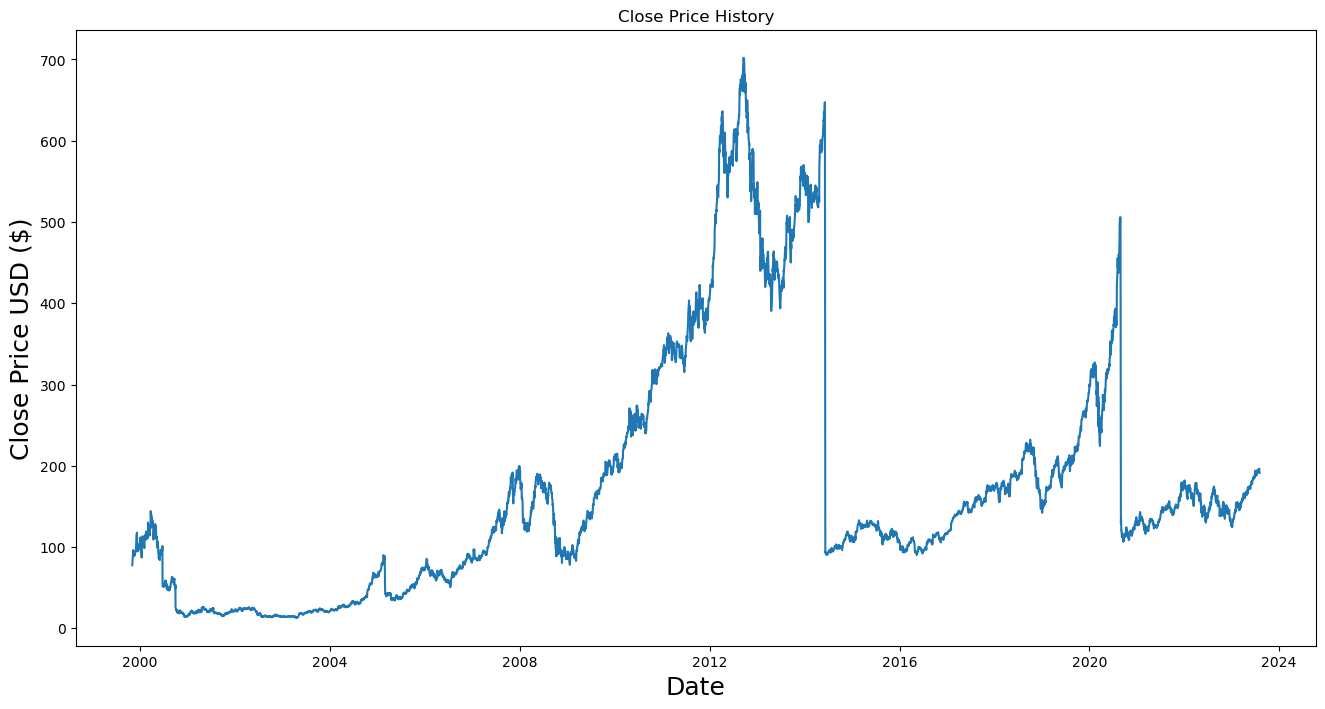

In [25]:
# Import Alpha Vantage API key
with open('/kaggle/input/api-key/API_KEY.txt', 'r') as file:
    API_KEY = file.read().strip()

# Define the company to get stock data for
symbol = 'AAPL'

# Initialize the TimeSeries class with your key
ts = TimeSeries(key=API_KEY, output_format='pandas')

# Get the last 100 days of daily time series data in a pandas dataframe
data, meta_data = ts.get_daily(symbol=symbol, outputsize='full')

# Reverse the order of the dataframe (earliest to latest)
data = data.iloc[::-1]

# Use the adjusted close prices for the prediction
data = data[['4. close']]

# Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(data['4. close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [26]:
# Split the data into train and test datasets
dataset = data.values
train_data_len = int(np.ceil( len(dataset) * .8 ))

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

train_data = scaled_data[0:int(train_data_len), :]
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
        
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


In [27]:
# Specify the number of GPUs
num_gpus = 2

# Use the 'tf.distribute.MirroredStrategy'
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    # Define your model within the strategy's scope
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=25))
    model.add(Dense(units=1))

    # Compile the model within the strategy scope
    model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(x_train, y_train, epochs=100, batch_size=32)


Epoch 1/100
148/148 [==============================] - 11s 17ms/step - loss: 0.0060
Epoch 2/100
148/148 [==============================] - 3s 17ms/step - loss: 0.0017
Epoch 3/100
148/148 [==============================] - 3s 23ms/step - loss: 0.0017
Epoch 4/100
148/148 [==============================] - 3s 18ms/step - loss: 0.0012
Epoch 5/100
148/148 [==============================] - 3s 17ms/step - loss: 0.0012
Epoch 6/100
148/148 [==============================] - 3s 18ms/step - loss: 0.0011
Epoch 7/100
148/148 [==============================] - 3s 18ms/step - loss: 0.0012
Epoch 8/100
148/148 [==============================] - 3s 17ms/step - loss: 0.0010
Epoch 9/100
148/148 [==============================] - 3s 17ms/step - loss: 9.9493e-04
Epoch 10/100
148/148 [==============================] - 3s 17ms/step - loss: 9.7050e-04
Epoch 11/100
148/148 [==============================] - 3s 18ms/step - loss: 9.7066e-04
Epoch 12/100
148/148 [==============================] - 3s 17ms/step - l

In [28]:
# Create a new array containing scaled values from index 1543 to 2003 
test_data = scaled_data[train_data_len - 60: , : ]
# Create the datasets x_test and y_test
x_test = []
y_test = dataset[train_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))


38/38 [==============================] - 2s 8ms/step
The root mean squared error is 12.157815404603902.


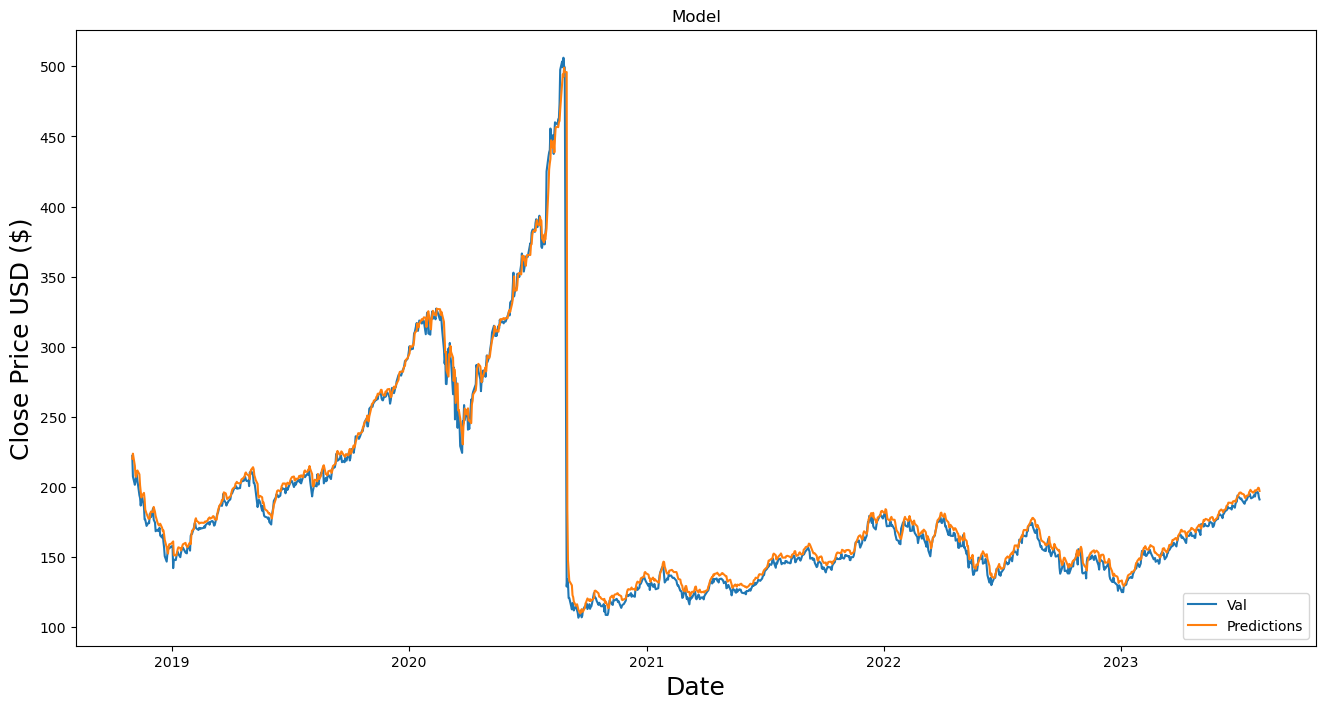

In [29]:
# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Create a DataFrame for the valid data
valid = data[train_data_len:].copy()  # Create a copy to avoid SettingWithCopyWarning

# Add the predictions to the valid DataFrame
valid.loc[:, 'Predictions'] = predictions

# Calculate root mean squared error
rmse = math.sqrt(mean_squared_error(valid['4. close'], valid['Predictions']))

print("The root mean squared error is {}.".format(rmse))

# Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(valid[['4. close']])
plt.plot(valid[['Predictions']])
plt.legend(['Val', 'Predictions'], loc='lower right')
plt.show()



In [ ]:
# Train ARIMA model
# Use the original 'Close' values for this
training_data = data['4. close'][:train_data_len]
testing_data = data['4. close'][train_data_len:]

history = [x for x in training_data]
predictions_arima = list()

# We use the same test data as for the LSTM
for t in range(len(testing_data)):
    model_arima = ARIMA(history, order=(5,1,0)) # adjust the parameters as needed
    model_arima_fit = model_arima.fit()
    output = model_arima_fit.forecast()
    predictions_arima.append(output[0])
    history.append(testing_data[t])

# Calculate RMSE for ARIMA
rmse_arima = math.sqrt(mean_squared_error(testing_data, predictions_arima))
print('The RMSE of the ARIMA model is {}.'.format(rmse_arima))

# Plot the ARIMA predictions against actual values
plt.figure(figsize=(16,8))
plt.title('ARIMA Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(testing_data.index, testing_data.values)
plt.plot(testing_data.index, predictions_arima, color='red')
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()